In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import collections
import IPython
import pandas
import numpy as np

## Utilities for numerical optimization

In [2]:
import signal
class Interruptable():
    class Breakout(Exception):
        pass
    def __init__(self):
        self.interrupted = False
        self.orig_handler = None
    def __enter__(self):
        self.orig_handler = signal.getsignal(signal.SIGINT)
        signal.signal(signal.SIGINT, self.handle)
        return self.check
    def __exit__(self, exc_type, exc_val, exc_tb):
        signal.signal(signal.SIGINT, self.orig_handler)
        if exc_type == Interruptable.Breakout:
            print(' stopped')
            return True
        return False
    def handle(self, signal, frame):
        if self.interrupted:
            self.orig_handler(signal, frame)
        print('Interrupting ...', end='')
        self.interrupted = True
    def check(self):
        if self.interrupted:
            raise Interruptable.Breakout
            
def enumerate_cycle(g, shuffle=True):
    epoch = 0
    while True:
        if shuffle:
            for i,j in enumerate(np.random.permutation(len(g))):
                yield (epoch,i), g[j]
        else:
            for i,x in enumerate(g):
                yield (epoch,i), x
        epoch = epoch + 1
        
        
import contextlib
@contextlib.contextmanager
def test_time(module):
    was_training = module.training
    module.train(False)
    with torch.no_grad():
        try:
            yield
        finally:
            module.train(was_training)

# Data generation

In [3]:
import sklearn.gaussian_process as gp

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared, WhiteKernel, RBF

In [51]:
# sample two values from ~N(0, 2) repeat them to be in the same size of sequence length and then permute


k = RBF() + WhiteKernel(0.005)
gp = GaussianProcessRegressor(kernel=k)
t = np.concatenate([np.linspace(1920,2100,T//2), np.linspace(1920,2100,T-T//2)])
e = np.random.permutation(np.tile(np.random.normal(0, 12, 2), T//2)).reshape(-1, 1)
idd = (e == np.unique(e)[0])
y = gp.sample_y(t.reshape(-1, 1)) + e.reshape(-1, 1)

In [52]:
gp.sample_y(t.reshape(-1, 1)).shape

(100, 1)

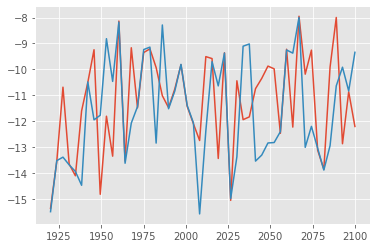

In [53]:
plt.plot(t[:50], y[:50])
plt.plot(t[50:], y[50:])

In [4]:
# t.shape = k.shape = (T)
# y.shape = (N,T)
# T = sequence length, N = num. samples

rng = np.random.default_rng(seed=16181)

N = 10000
T = 100
k = 0.05*gp.kernels.RBF() + gp.kernels.WhiteKernel(0.005)
Y = gp.GaussianProcessRegressor(kernel=k)
t = np.concatenate([np.linspace(1920,2100,T//2), np.linspace(1920,2100,T-T//2)])
k = np.concatenate([np.zeros(T//2, dtype=int), np.ones(T-T//2, dtype=int)])
e = 1.2*rng.normal(size=N)
y = Y.sample_y(t[:,None], n_samples=N, random_state=1618) + k[:,None]*e[None,:]
y = y.T

GaussianSample = collections.namedtuple('TrainingData', ['t','k','y'])
training_data = GaussianSample(t=torch.tensor(t, dtype=torch.float32), k=torch.tensor(k), y=torch.tensor(y[:-100], dtype=torch.float32))
test_data = GaussianSample(t=training_data.t, k=training_data.k, y=torch.tensor(y[-100:], dtype=torch.float32))

In [1]:
# sample two values from ~N(0, 2) repeat them to be in the same size of sequence length and then permute
e = np.random.permutation(np.tile(np.random.normal(0, 2, 2), seq_len)).reshape(-1, 1)
idd = (e == np.unique(e)[0])
y = gp.sample_y(x.reshape(-1, 1)) + e

NameError: name 'np' is not defined

In [33]:
t.shape

(100,)

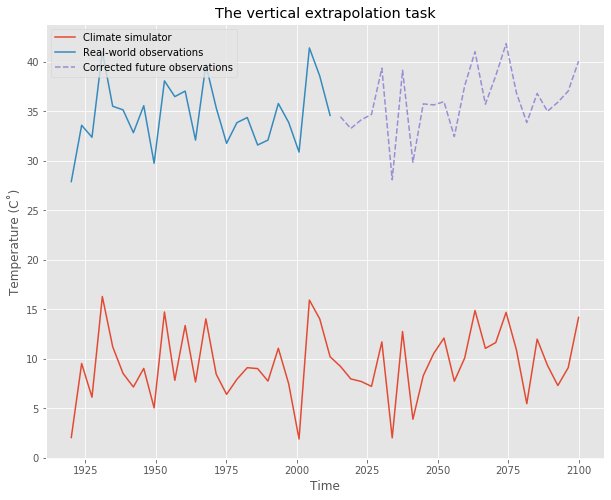

In [5]:
plt.style.use('ggplot')
fig,ax = plt.subplots(figsize =(10, 8))
plt.title('The vertical extrapolation task')
plt.xlabel('Time')
plt.ylabel('Temperature (C˚)')
ax.plot(t[:50], y[0][:50]*15 + 10, label = 'Climate simulator')
ax.plot(t[50:76], y[0][50:76]* 15 + 20, label = 'Real-world observations')
ax.plot(t[76:], y[0][76:]* 15 + 20, linestyle ='dashed', label = 'Corrected future observations')
plt.legend(loc =2)
plt.show()

# Pre-probability model

In [17]:
class TransformerGenerator(nn.Module):
    """A stack of transformer-generators, mostly as described in the Attention paper and implemented in nn.Transformer.
    Difference: the sequence data has (x,y) pairs, where x∈ℝ(dx) is coordinate and y∈ℝ(dy) is reading.
    
    Prediction (one-shot, as in a Gaussian Process ribbon plot):
    conditional on y[0]...y[T-1] at x[0]...x[T-1], predict Y value at each of xnew[0]...xnew[Tpred-1]]
    
    Sampling (as in Gaussian Process sample_y):
    conditional on y[0]...y[T-1] at x[0]...x[T-1], jointly synthesize Y values at xnew[0]...x[Tpred-1] 
    We should really have learnt σ from the training procedure, but to keep things simple I'll hardwire it.

    LogLikelihood [forward function] (a cheating implementation):
    treat y[0]...y[-Tpred-1] as given, do one-shot prediction of y[-Tpred]...y[-1],
    and compare those predictions to what actually happened
    (This should really be a proper teacher-forced log likelihood, as in RNNs.
    But I'm worried it'll take ages to learn to make good long-range extrapolations,
    so instead I'll ask for one-shot predictions at a whole slew of future timepoints,
    and hope it learns the general principle.)
    """
    
    def __init__(self, dx, dy, num_layers, **kwargs):
        super().__init__()
        d = dx + dy + 1
        self.layers = nn.ModuleList([TransformerPredictionLayer(d=d, **kwargs) for _ in range(num_layers)])
        self.fc = nn.Linear(d, dy)
        
    def predict(self, x, y, xnew): 
        # x.shape=(S,B,dx)  y.shape=(S,B,dy)  xnew.shape=(L,B,dx)  return.shape=(L,B,dy)
        T,B,dy = y.shape
        Tpred,_,_ = xnew.shape
        z = torch.cat([x, y, torch.zeros((T,B,1))], dim=2)
        znew = torch.cat([xnew, torch.zeros((Tpred,B,dy)), torch.ones((Tpred,B,1))], dim=2)
        qkv = torch.cat([z, znew], dim=0)
        for ℓ in self.layers:
            qkv = ℓ(qkv)
        return self.fc(qkv[-Tpred:])
    
    def sample(self, x, y, xnew, σ):
        # x.shape=(T,dx)  y.shape=(T,dy)   xnew.shape=(Tpred,dx)
        T,dy = y.shape
        Tpred,_ = xnew.shape
        xall = torch.cat([x, xnew], dim=0)
        yall = torch.cat([y, torch.full(size=(Tpred,dy), fill_value=np.nan)], dim=0)
        with test_time(self):
            for i in range(T, T+Tpred):
                ynext = self.predict(x=xall[:i-1,None,:], y=yall[:i-1,None,:], xnew=xall[i:i+1,None,:])[0,0]
                yall[i] = torch.normal(mean=ynext, std=σ)
        return yall[-Tpred:]

    def forward(self, x, y, Tpred=1): # return.shape=(1,B)
        pred = self.predict(x[:-Tpred], y[:-Tpred], x[-Tpred:]) # shape=(Tpred,B,dy)
        return - torch.mean((y[-Tpred:] - pred)**2, dim=[0,2])        
    

class TransformerPredictionLayer(nn.Module):
    """A layer of a Transformer-Decoder, except that the Encoder has been merged in."""
    
    def __init__(self, d, num_heads, dim_fc, dropout):
        super().__init__()
        self.d = d
        self.attn = nn.MultiheadAttention(embed_dim=d, num_heads=num_heads, dropout=dropout)
        self.fc1, self.fc2 = nn.Linear(d, dim_fc), nn.Linear(dim_fc, d)
        self.dropout1, self.dropout2, self.dropout_fc = [nn.Dropout(dropout) for _ in range(3)]
        self.norm1, self.norm2 = [nn.LayerNorm(d) for _ in range(2)]
        self._masks = {}

    def forward(self, qkv, Tpred=1):
        # qkv.shape=(T,B,d), return.shape=(T,B,d)
        # T=sequence_length, B=batch_size, final Tpred to be predicted based on previous
        T,_,_ = qkv.shape
        z0 = qkv
        δ1,_ = self.attn(query=qkv, key=qkv, value=qkv, attn_mask=self._mask(T,Tpred))
        z1 = self.norm1(z0 + self.dropout1(δ1))
        δ2 = F.relu(self.fc1(z1))
        δ2 = self.fc2(self.dropout_fc(δ2))
        z2 = self.norm2(z1 + self.dropout2(δ2))
        return z2
    
    def _mask(self, T, Tpred):
        if (T,Tpred) not in self._masks:
            #m = torch.zeros((T,T), dtype=torch.bool) # uses T-Tpred as predictors
            m = torch.triu(torch.ones((T,T), dtype=torch.bool), diagonal=1) # fully generative
            m[:, -Tpred:] = True
            self._masks[(T,Tpred)] = m
        return self._masks[(T,Tpred)]
    

def embed_position(t, d, TΔmin, Tmax):  # return.shape=(T,B,d)
    # t.shape=(T,B)   T=sequence_length, B=batch_size
    """A position-embedder, similar to the Attention paper, but tweaked to account for
    floating point positions, rather than integer.
    """
    R = Tmax / TΔmin * 100
    drange_even = TΔmin * R**(torch.arange(0,d,2)/d)
    drange_odd = TΔmin * R**((torch.arange(1,d,2) - 1)/d)
    x = torch.cat([torch.sin(t[:,:,None] / drange_even), torch.cos(t[:,:,None] / drange_odd)], 2)
    return x

# Training

In [18]:
# Prepare the embedded x-coordinates (embed_position(t) ++ one_hot(k))

x1 = embed_position(training_data.t[:,None], d=8, TΔmin=0.2, Tmax=30)
x2 = F.one_hot(training_data.k[:,None], num_classes=2)
x = torch.cat([x1,x2], 2)

In [19]:
t.shape

(100,)

In [20]:
x1.shape

torch.Size([100, 1, 8])

In [21]:
x

tensor([[[-0.1324,  0.7724,  0.2027,  0.0184,  0.9912, -0.6352,  0.9792,
           0.9998,  1.0000,  0.0000]],

        [[ 0.7756,  0.7106,  0.2109,  0.0192,  0.6312, -0.7036,  0.9775,
           0.9998,  1.0000,  0.0000]],

        [[ 0.9437,  0.6428,  0.2190,  0.0199, -0.3309, -0.7660,  0.9757,
           0.9998,  1.0000,  0.0000]],

        [[ 0.2115,  0.5696,  0.2271,  0.0207, -0.9774, -0.8219,  0.9739,
           0.9998,  1.0000,  0.0000]],

        [[-0.7224,  0.4915,  0.2352,  0.0215, -0.6915, -0.8709,  0.9719,
           0.9998,  1.0000,  0.0000]],

        [[-0.9672,  0.4092,  0.2433,  0.0222,  0.2541, -0.9124,  0.9699,
           0.9998,  1.0000,  0.0000]],

        [[-0.2893,  0.3234,  0.2514,  0.0230,  0.9572, -0.9462,  0.9679,
           0.9997,  1.0000,  0.0000]],

        [[ 0.6646,  0.2349,  0.2594,  0.0237,  0.7472, -0.9720,  0.9658,
           0.9997,  1.0000,  0.0000]],

        [[ 0.9845,  0.1444,  0.2675,  0.0245, -0.1756, -0.9895,  0.9636,
           0.9997,  1.0

In [22]:
B = 20   # batch size
y_batches = torch.utils.data.DataLoader(training_data.y, batch_size=B)
x_batch = x.repeat(1,B,1)
iter_training = enumerate_cycle(y_batches, shuffle=False)

In [23]:
mymodel = TransformerGenerator(dx=x.shape[-1], dy=1, num_layers=4, num_heads=3, dim_fc=8, dropout=0.0)
mymodel.load_state_dict(torch.load('transformer1_1299epoch.pt'))

<All keys matched successfully>

In [24]:
optimizer = torch.optim.Adam(mymodel.parameters())

with Interruptable() as check_interrupted:
    for (epoch,batch_num),y_batch in iter_training:
        check_interrupted()
        optimizer.zero_grad()
        loglik = mymodel(x_batch, y_batch.T[:,:,None], Tpred=30)
        e = - torch.mean(loglik)
        e.backward()
        optimizer.step()
        IPython.display.clear_output(wait=True)
        print(f'batch={batch_num+1}:{epoch} loglik={-e.item():.5}')

batch=15:1 loglik=-0.059099
 stopped


In [25]:
torch.save(mymodel.state_dict(), 'transformer1_1299epoch.pt')

### Test output

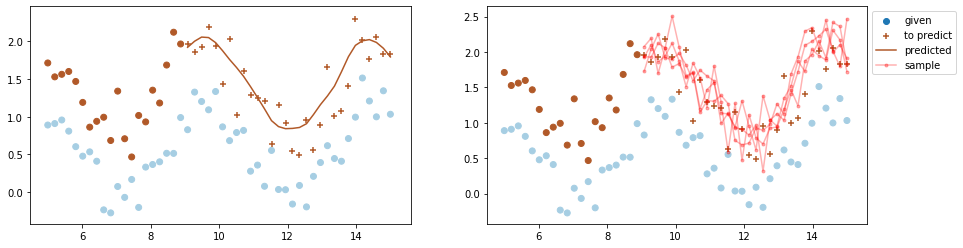

In [32]:
df = pandas.DataFrame({'t': test_data.t, 'k': test_data.k, 
                       'yobs': test_data.y[3], 
                       'given': np.repeat([True,False], [70,30]), 
                       'ypred': np.nan
                      })

# For these plots, I'm only predicting values for one of the two sequences.
g = df.given
kpred = df.k[~df.given].unique()
assert len(kpred) == 1
kpred = kpred[0]

xtest = x  # training and test data have the same x
pred = mymodel.predict(xtest[g], torch.tensor(df.yobs[g])[:,None,None], xtest[~g])[:,0,0].detach().numpy()
df.loc[~g, 'ypred'] = pred

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(15,4))
cmap = plt.get_cmap('Paired', 2)
for ax in [ax1,ax2]:
    lgiven = ax.scatter(df.t[g], df.yobs[g], c=df.k[g], cmap=cmap, label='given')
    lunseen = ax.scatter(df.t[~g], df.yobs[~g], color=cmap(kpred), marker='+', label='to predict')
lpred, = ax1.plot(df.t[~g], df.ypred[~g], color=cmap(kpred), label='predicted')
for _ in range(4):
    samp = mymodel.sample(xtest[g][:,0,:], torch.tensor(df.yobs[g])[:,None], xtest[~g][:,0,:], σ=np.sqrt(0.06))[:,0].detach().numpy()
    lsamp, = ax2.plot(df.t[~g], samp, color='red', label='sample', marker='.', alpha=.3)
plt.legend(handles=[lgiven,lunseen,lpred,lsamp], bbox_to_anchor=(1,1), loc='upper left')
plt.show()

## Reference: documentation for torch.nn.MultiHeadAttention
https://pytorch.org/docs/master/generated/torch.nn.MultiheadAttention.html#torch.nn.MultiheadAttention

```python
# embed_dim: total dimension of the model.
# num_heads: parallel attention heads.
# dropout: a Dropout layer on attn_output_weights. Default: 0.0.
# bias: add bias as module parameter. Default: True.
# add_bias_kv: add bias to the key and value sequences at dim=0.
# add_zero_attn: add a new batch of zeros to the key and value sequences at dim=1.
# kdim: total number of features in key. Default: embed_dim
# vdim: total number of features in value. Default: embed_dim

mha = MultiheadAttention(embed_dim, num_heads, dropout=0., bias=True, add_bias_kv=False, add_zero_attn=False, kdim=None, vdim=None)
mha(query, key, value, key_padding_mask=None, need_weights=True, attn_mask=None)
```


#### Args:
*        query, key, value: map a query and a set of key-value pairs to an output.
            See "Attention Is All You Need" for more details.
*        key_padding_mask: if provided, specified padding elements in the key will
            be ignored by the attention. When given a binary mask and a value is True,
            the corresponding value on the attention layer will be ignored. When given
            a byte mask and a value is non-zero, the corresponding value on the attention
            layer will be ignored
*        need_weights: output attn_output_weights.
*        attn_mask: 2D or 3D mask that prevents attention to certain positions. A 2D mask will be broadcasted for all
            the batches while a 3D mask allows to specify a different mask for the entries of each batch.

####    Shapes for inputs:
* query: $(L, N, E)$ where L is the target sequence length, N is the batch size, E is
  the embedding dimension.
* key: $(S, N, E)$, where S is the source sequence length, N is the batch size, E is
  the embedding dimension.
* value: $(S, N, E)$ where S is the source sequence length, N is the batch size, E is
  the embedding dimension.
* key_padding_mask: $(N, S)$ where N is the batch size, S is the source sequence length.
  If a ByteTensor is provided, the non-zero positions will be ignored while the position
  with the zero positions will be unchanged. If a BoolTensor is provided, the positions with the
  value of ``True`` will be ignored while the position with the value of ``False`` will be unchanged.
* attn_mask:
  * if a 2D mask: $(L, S)$ where L is the target sequence length, S is the
    source sequence length.
  * If a 3D mask: $(N\cdot\text{num_heads}, L, S)$ where N is the batch size, L is the target sequence
    length, S is the source sequence length. 
  * ``attn_mask`` ensure that position i is allowed to attend
the unmasked positions. If a ByteTensor is provided, the non-zero positions are not allowed to attend
while the zero positions will be unchanged. If a BoolTensor is provided, positions with ``True``
is not allowed to attend while ``False`` values will be unchanged. If a FloatTensor
is provided, it will be added to the attention weight.

####    Shapes for outputs:
* attn_output: $(L, N, E)$ where L is the target sequence length, N is the batch size,
  E is the embedding dimension.
* attn_output_weights: $(N, L, S)$ where N is the batch size,
  L is the target sequence length, S is the source sequence length.